In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from ensemble.distributions import distribution_dict
from ensemble.model import EnsembleFitter, EnsembleDistribution

# Fitting individual distributions

from optim:  3.884735954637275 7.522578208952956


/Users/maxbi/opt/anaconda3/envs/ensemble/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:2509: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


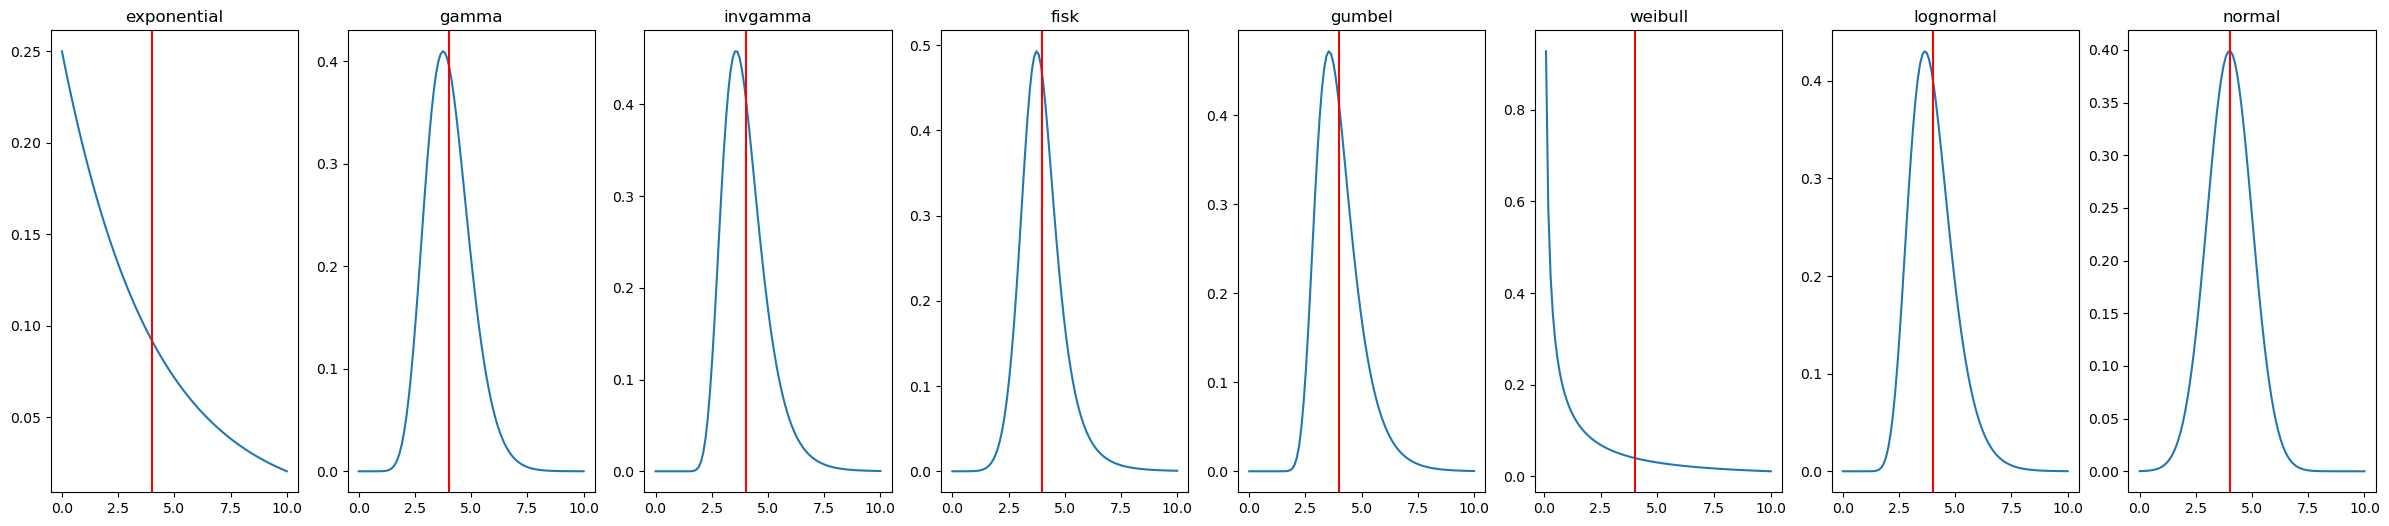

In [2]:
MEAN = 4
VARIANCE = 1
fitted_distributions = {}
counter = 0
fig, ax = plt.subplots(1, len(distribution_dict) - 1, figsize=(30, 6))
for distribution in distribution_dict:
  if distribution != "beta":
    fitted_distributions[distribution] = distribution_dict[distribution](MEAN, VARIANCE)
    support = np.linspace(0, 10, 100)
    pdf = fitted_distributions[distribution].pdf(support)
    ax[counter].plot(support, pdf)
    ax[counter].axvline(MEAN, color="red")
    ax[counter].title.set_text(distribution)
    counter += 1


# Fitting ensemble distributions

from optim:  3.884735954637275 7.522578208952956
from optim:  3.884735954637275 7.522578208952956
from optim:  3.884735954637275 7.522578208952956


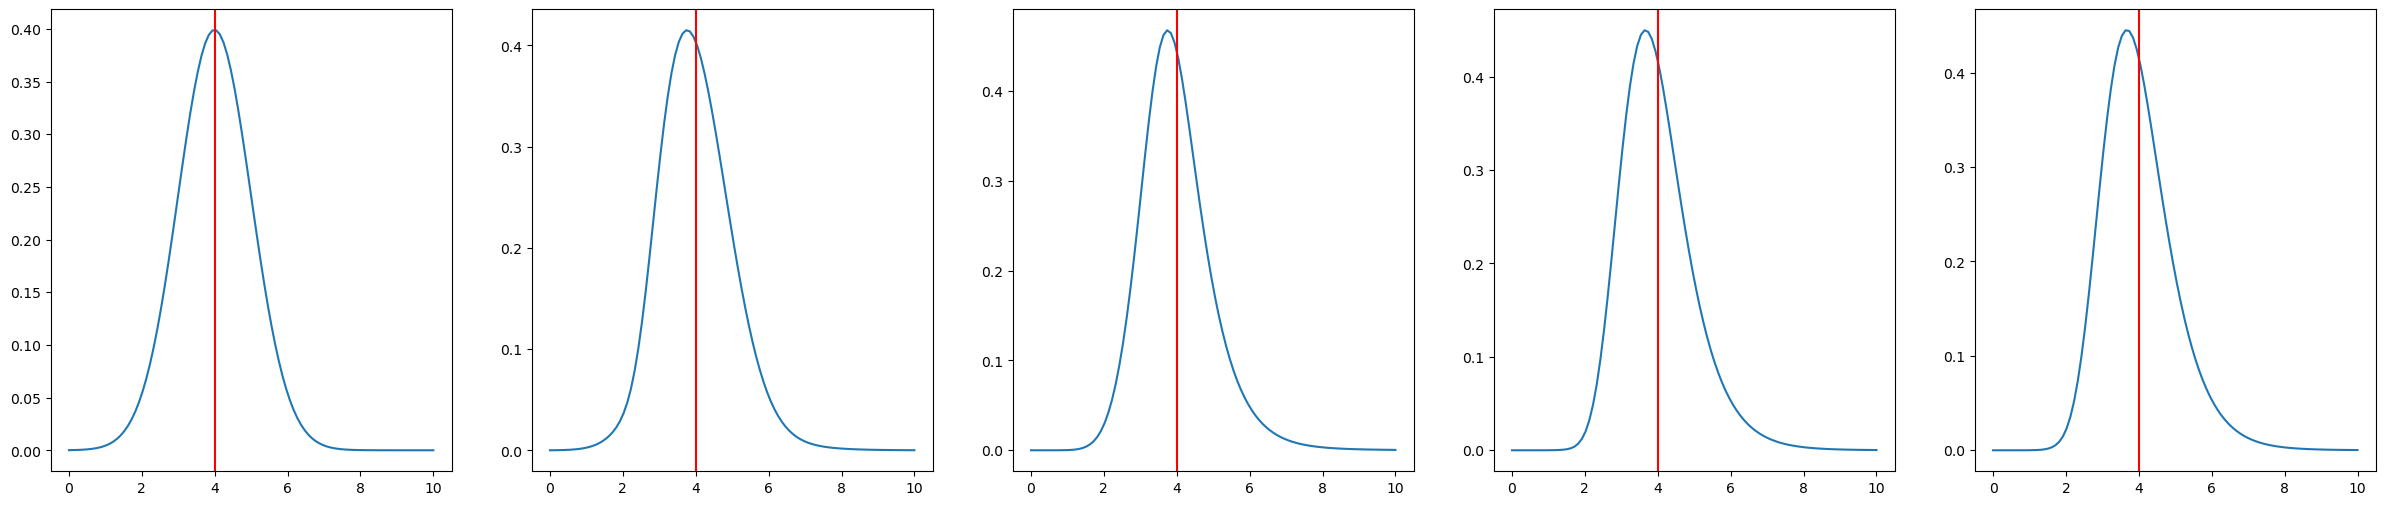

In [3]:
support = np.linspace(0, 10, 100)

def plot_ensembles(distributions, weights, mean, variance, support, figsize):
  fig, ax = plt.subplots(1, len(distributions), figsize=figsize)
  for i in range(len(distributions)):
    mod = EnsembleDistribution(distributions[i], weights[i], mean, variance)
    pdf = mod.pdf(support)
    ax[i].plot(support, pdf)
    ax[i].axvline(mean, color="red")

distributions = [["normal", "gumbel"],
                 ["normal", "gumbel"],
                 ["gamma", "fisk"],
                 ["invgamma", "lognormal", "fisk"],
                 ["gamma", "invgamma", "lognormal", "fisk"]]

weights = [[0.99, 0.01], [0.6, 0.4], [0.3, 0.7], [0.3, 0.5, 0.2], [0.2, 0.3, 0.3, 0.2]]

plot_ensembles(distributions, weights, MEAN, VARIANCE, support, (30, 6))

# Comparing fitted ensemble distributions to truth

from optim:  3.884735954637275 7.522578208952956
from optim:  3.884735954637275 7.522578208952956
from optim:  3.8891463366368657 7.608019189360023
from optim:  3.8891463366368657 7.608019189360023
from optim:  3.884735954637275 7.522578208952956
from optim:  3.884735954637275 7.522578208952956
from optim:  3.8833175144582497 7.590649346762972
from optim:  3.8833175144582497 7.590649346762972
from optim:  3.884735954637275 7.522578208952956
from optim:  3.884735954637275 7.522578208952956
from optim:  3.8864281951694744 7.42138024134743
from optim:  3.8864281951694744 7.42138024134743


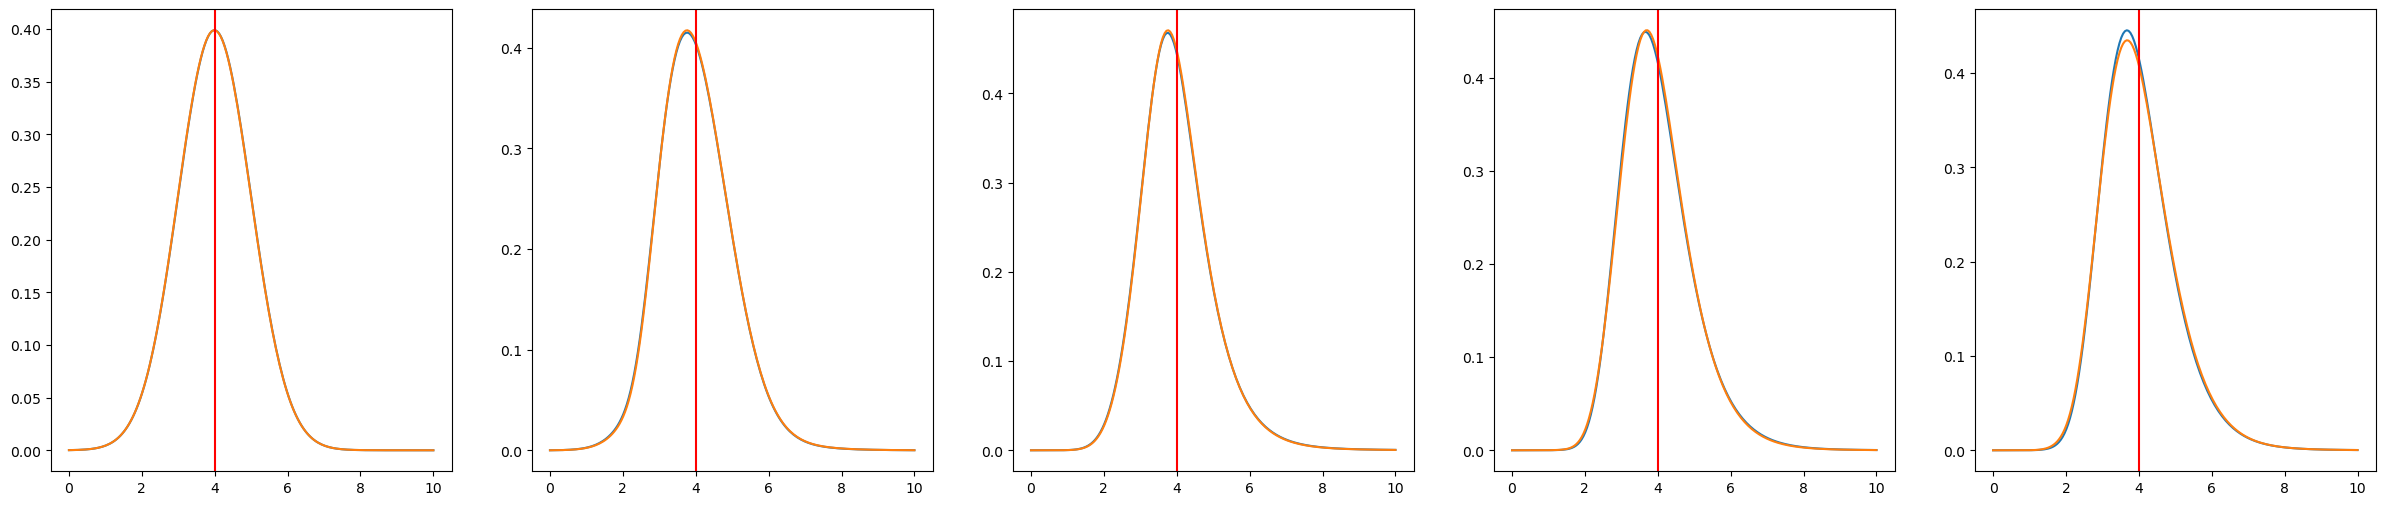

In [4]:
support = np.linspace(0, 10, 200)

def ensemble_comparison(distributions, weights, objective, mean, variance, support, figsize):
  fig, ax = plt.subplots(1, len(distributions), figsize=figsize)
  for i in range(len(distributions)):
    mod = EnsembleDistribution(distributions[i], weights[i], mean, variance)
    mod_draws = mod.rvs(size=10000)
    fit = EnsembleFitter(distributions[i], objective).fit(mod_draws)
    pdf = mod.pdf(support)
    ax[i].plot(support, pdf)
    ax[i].plot(support, fit.ensemble_distribution.pdf(support))
    ax[i].axvline(mean, color="red")

distributions = [["normal", "gumbel"],
                 ["normal", "gumbel"],
                 ["gamma", "fisk"],
                 ["invgamma", "lognormal", "fisk"],
                 ["gamma", "invgamma", "lognormal", "fisk"]]

weights = [[0.99, 0.01], [0.6, 0.4], [0.3, 0.7], [0.3, 0.5, 0.2], [0.2, 0.3, 0.3, 0.2]]

ensemble_comparison(distributions, weights, "KS", MEAN, VARIANCE, support, (30, 6))

# How does Scipy work?

In [5]:
# helper funcs
def reverse_z(z, mean, variance):
  return z * np.sqrt(variance) + mean

(4.0, 1.0)
0.022750131948179195


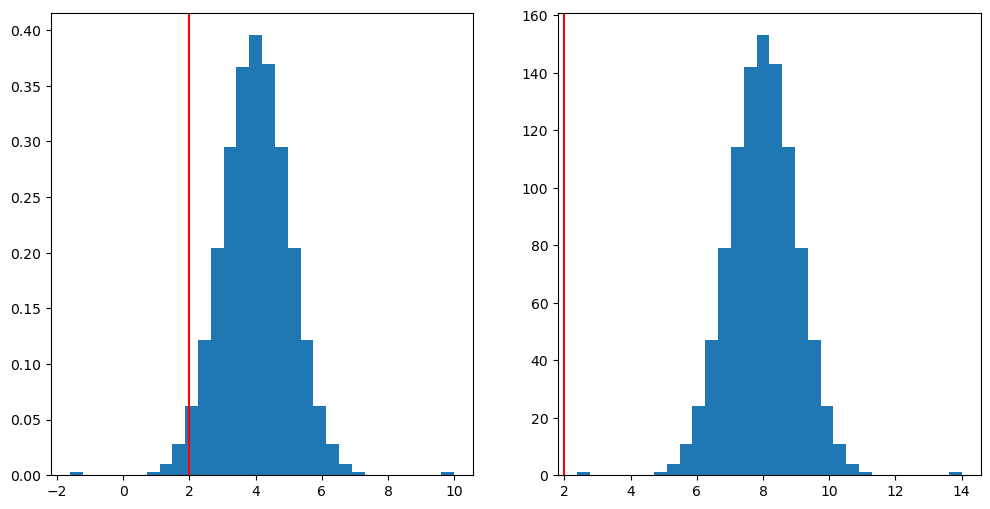

In [6]:
# initialize Normal(0, 1)
MEAN = 4
VARIANCE = 1
std_norm = distribution_dict["normal"](MEAN, VARIANCE)
print(std_norm.stats(moments="mv"))
support_01 = np.linspace(0.00000001, 0.999999999, 1000)
quantiles = std_norm.ppf(support_01)
vals = reverse_z(quantiles, MEAN, VARIANCE)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(quantiles, density=True, bins=30)
quantile = 2
print(std_norm.cdf(quantile))
ax[0].axvline(quantile, color="red")

ax[1].hist(vals, bins=30)
ax[1].axvline(quantile, color="red")
plt.show()





* this shows that cdf and pdf take values from the real line, as if cdf were to take 